<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Заитов Никита Алексеевич

**Забавный факт о себе:** наиграл 3000 часов в симуляторе пчеловода в роблоксе

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [3]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [5]:
import gdown
import os



url = "XXXX"
gdown.download_folder(url, quiet=True, use_cookies=False)

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [6]:

df_ria = pd.read_csv(f'{foldername}/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


In [7]:
df_ria['snippet'].apply(len).median()

712.0

Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [8]:
df_vk = pd.read_csv(f'{foldername}/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [9]:
df_comments = pd.read_csv(f'{foldername}/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

C:\Users\nasty\AppData\Local\Temp\ipykernel_19536\3455493110.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv(f'{foldername}/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [10]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [11]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

In [12]:
target_tags_jorted = sorted(list(target_tags))

Закодируем теги для OHE.

In [13]:
tag2idx = dict(zip(target_tags_jorted, range(len(target_tags_jorted))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

In [14]:
tag2idx

{'"бессмертный полк" - 2018': 0,
 '"дом.рф"': 1,
 '"новая" москва': 2,
 '"общественные мнения"': 3,
 '"прямая линия" с путиным - 2018': 4,
 '13 мая': 5,
 '13-15 апреля': 6,
 '17 марта': 7,
 '19-25 марта': 8,
 '2-15 июля 2018 года': 9,
 '2002': 10,
 '2003': 11,
 '2004': 12,
 '2005': 13,
 '2007': 14,
 '21-23 апреля': 15,
 '22-25 марта': 16,
 '23 марта 2018 года': 17,
 '23-й тур чемпионата россии-2017/18 по футболу': 18,
 '24-й тур чемпионата россии-2017/18 по футболу': 19,
 '25-й тур чемпионата россии-2017/18 по футболу': 20,
 '26-29 апреля 2018 года': 21,
 '26-й тур чемпионата россии-2017/18 по футболу': 22,
 '27 марта 2018 года': 23,
 '27-й тур чемпионата россии-2017/18 по футболу': 24,
 '28-30 апреля': 25,
 '28-й тур чемпионата россии-2017/18 по футболу': 26,
 '29-й тур чемпионата россии-2017/18 по футболу': 27,
 '30 мая и 5 июня 2017 года': 28,
 '30-й тур чемпионата россии-2017/18 по футболу': 29,
 '31 марта - 1 апреля': 30,
 '5-7 мая': 31,
 '6-7 апреля': 32,
 '7-9 апреля': 33,
 '73-

Почистим таргет от лишних тэгов.

In [15]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [16]:
df_ria.target_tags.values[:3]

array([list([235, 582, 263]), list([1546, 1452, 263]), list([1346])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [17]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nasty\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nasty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [19]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [20]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [21]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [22]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [23]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [24]:
# your code here
# ヽ(♡‿♡)ノ
df_vk['title_clean'] = df_vk.title.apply(normalise_text)

df_ria['snippet_clean'] = df_ria.snippet.apply(lambda x: normalise_text(x) if pd.notnull(x) else "#UNK#")
df_vk['snippet_clean'] = df_vk.snippet.apply(lambda x: normalise_text(x) if pd.notnull(x) else "#UNK#")
df_vk['snippet_clean']

0        #UNK#
1        #UNK#
2        #UNK#
3        #UNK#
4        #UNK#
         ...  
19923    #UNK#
19924    #UNK#
19925    #UNK#
19926    #UNK#
19927    #UNK#
Name: snippet_clean, Length: 19928, dtype: object

In [25]:
df_vk[df_vk['snippet_clean'] != "#UNK#"]['snippet_clean']

16       ранее в соцсетях появились кадры на которых за...
26       новый пулемет крупнокалиберный автомат и долго...
27       борис кондрашин более десяти лет проходил прин...
30       выставка вместе с возвращенным полотном айпетр...
33       сергей горданов из карельского города костомук...
                               ...                        
19880    почему затраты на ипотеку часто не окупаются и...
19881    и без того было понятно  чтото не то со страно...
19882    риа10vk друзья рассказываем вам какие гаджеты ...
19883    двадцать восьмого сентября в москве стартовали...
19914    как колумбийским школьникам можно рассказать о...
Name: snippet_clean, Length: 6525, dtype: object

## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [26]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


In [27]:
len(df_ria[~df_ria.href.isin(test_hrefs)])

200309

По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [28]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [29]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [30]:
df['date_dtime'] = pd.to_datetime(df['date'])

C:\Users\nasty\AppData\Local\Temp\ipykernel_19536\1830024031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_dtime'] = pd.to_datetime(df['date'])


In [31]:
# your code here
# ♡ (´｡• ω •｡`)
all_december = ["2018-12-01","2018-12-31"]
octomber_ovember = ["2018-10-01","2018-11-30"]

decmask = (df['date_dtime'] >= all_december[0]) & (df['date_dtime'] <= all_december[1])
octembermask = (df['date_dtime'] >= octomber_ovember[0]) & (df['date_dtime'] <= octomber_ovember[1])

df_test = df[decmask]
df_val = df[octembermask]
df_train = df[~(decmask | octembermask)]

тест 2018-12-01 00:00:00 2018-12-31 00:00:00 20176
валидация 2018-10-01 00:00:00 2018-11-30 00:00:00 43258
трейн 2018-03-15 00:00:00 2018-09-30 00:00:00 136875


Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [32]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1332, 1376]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[292, 263]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[1397, 1121]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[955]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[1251, 263]"


Напишем датасет для поставки данных в нейросеть.


In [34]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

       if snippet is not None:
            self.X_snippet = self.create_text(snippet, max_snippet_len)
       else:
            self.X_snippet = None

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if self.X_snippet is not None:
          return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])
        else:
          return (self.X_title[idx, :], self.y[idx])


__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [35]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# Внесите в код датасета выше свои правки

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [36]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [37]:
# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [38]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=56, num_workers=4, persistent_workers=True)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4, persistent_workers=True)

## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [39]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [40]:
#!pip3 install pytorch_lightning

In [41]:
#!pip install wandb
import wandb
wandb.login()

wandb: Currently logged in as: tangerine5 (tangerine5_t). Use `wandb login --relogin` to force relogin


True

In [42]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.save_hyperparameters(ignore=['model', 'criterion'])
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.save_hyperparameters()

    def forward(self, title):
        return self.model(title)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Обучим модель.

In [43]:
from pytorch_lightning.loggers import WandbLogger
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()
wandb_logger = WandbLogger(project="name", log_model='all')

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger)

c:\users\nasty\pycharmprojects\kr2\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\users\nasty\pycharmprojects\kr2\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [113]:
trainer.fit(train_module, train_dataloader, val_dataloader)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,▇█▆▆▆▄▅▅▄▅▄▃▄▄▃▃▃▂▄▂▂▄▃▂▂▂▂▂▁▂▃▂▂▂▁▂▂▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▁▁
epoch,4
train_loss,6.51513
trainer/global_step,12224
val_loss,10.72987


__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [ ]:
# your code here
# (￢_￢)
MAX_SNIPPET_LEN = 1250

# df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM
# self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None

train_dataset_two = NewsDataset(
    df_train['target_tags'].values,
    df_train['title_clean'].values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM,
    df_train['snippet_clean'].values,
    MAX_SNIPPET_LEN,
)

val_dataset_two = NewsDataset(
    df_val['target_tags'].values,
    df_val['title_clean'].values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM,
    df_val['snippet_clean'].values,
    MAX_SNIPPET_LEN,
)

train_dataloader_two = DataLoader(train_dataset_two, shuffle=True, batch_size=64, num_workers=4, persistent_workers = True)
val_dataloader_two = DataLoader(val_dataset_two, shuffle=False, batch_size=4096, num_workers=4, persistent_workers = True)

In [42]:
MAX_SNIPPET_LEN = 1250

test_dataset_two = NewsDataset(
    df_test['target_tags'].values,
    df_test['title_clean'].values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM,
    df_test['snippet_clean'].values,
    MAX_SNIPPET_LEN,
)

class BetterClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, title, snippet):
        embedded_t = self.embedding(title)
        embedded_s = self.embedding(snippet)
        embedded_t = embedded_t.mean(dim=1)
        embedded_s = embedded_s.mean(dim=1)
        embedded_c = torch.cat((embedded_t, embedded_s), dim=1)
        return self.fc(embedded_c)

In [43]:
class TrainLightningModuleTwo(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.save_hyperparameters(ignore=['model', 'criterion'])

    def forward(self, title, snippet):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, snippet, target = train_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, snippet, target = val_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

model_baseline_two = BetterClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
wandb_logger_two = WandbLogger(project="name", log_model='all')

train_module_two =TrainLightningModuleTwo(model_baseline_two, LR, criterion)

trainer_two = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger = wandb_logger_two)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [116]:
trainer_two.fit(train_module_two, train_dataloader_two, val_dataloader_two)

# Log metrics to WandB
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | BetterClassifier | 4.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.806    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,▆▆█▅▄▄▅▅▄▄▂▄▃▄▃▃▂▃▃▂▁▃▃▁▂▂▃▂▁▁▃▃▁▁▂▁▂▁▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▁▁
epoch,4
train_loss,8.74839
trainer/global_step,10694
val_loss,10.91697


## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [86]:
model_baseline_g = TrainLightningModule.load_from_checkpoint(f"driving-directly-into-a-brick-wall/xk4b4t9k/checkpoints/epoch=4-step=12225.ckpt")

class BetterClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, title, snippet):
        embedded_t = self.embedding(title)
        embedded_s = self.embedding(snippet)
        embedded_t = embedded_t.mean(dim=1)
        embedded_s = embedded_s.mean(dim=1)
        embedded_c = torch.cat((embedded_t, embedded_s), dim=1)
        return self.fc(embedded_c)

CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20
EMBEDDING_DIM = 300

model_baseline_two = BetterClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)

model_baseline_two_g = TrainLightningModuleTwo.load_from_checkpoint(f"driving-sideways-into-a-brick-wall/toaqhlyo/checkpoints/epoch=4-step=10695.ckpt", model = model_baseline_two, criterion = torch.nn.CrossEntropyLoss()).eval()

In [50]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [93]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

with torch.no_grad():
    for title, target in test_dataloader:
        logit = model_baseline_g.to(device).forward(title.to(device))
        pred_prob = F.softmax(logit, dim=1)
    
    assert pred_prob.shape[0] == test_dataset.__len__()

TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target.to(device), y_pred))
print('Precision:', precision(target.to(device), y_pred))
print('Recall:', recall(target.to(device), y_pred))

Exact Match: 0.9955159425735474
Precision: 0.2915295958518982
Recall: 0.7650487422943115


Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [96]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob.to(device) > TRESHOLD)

print('Exact Match:', exact_match(target.to(device), y_pred))
print('Precision:', precision(target.to(device), y_pred))
print('Recall:', recall(target.to(device), y_pred))

Exact Match: 0.9955159425735474
Precision: 0.2915295958518982
Recall: 0.7650487422943115


In [97]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob.to(device) > TRESHOLD)
print('Exact Match:', exact_match(target.to(device), y_pred))
print('Precision:', precision(target.to(device), y_pred))
print('Recall:', recall(target.to(device), y_pred))

Exact Match: 0.9983294606208801
Precision: 0.5234103202819824
Recall: 0.6234884262084961


In [98]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob.to(device) > TRESHOLD)

print('Exact Match:', exact_match(target.to(device), y_pred))
print('Precision:', precision(target.to(device), y_pred))
print('Recall:', recall(target.to(device), y_pred))

Exact Match: 0.9983185529708862
Precision: 0.006344107910990715
Recall: 0.005646093282848597


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [44]:
def get_predict(model, dataset):
    if dataset.X_snippet is None:
        dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())
    else:
        dataloader = DataLoader(dataset, shuffle=False, batch_size=128)
    
    with torch.no_grad():
        if dataset.X_snippet is None:
            for title, target in dataloader:
                logit = model(title.to(device))
                pred_prob = F.softmax(logit, dim=1)
        else:
            pred_prob = None
            target_t = None
            for title, snippet, target in (tqdm(dataloader)):
                logit = model(title.to(device), snippet.to(device))
                pred_prob_t = F.softmax(logit, dim=1)
                if pred_prob == None:
                    pred_prob = pred_prob_t.detach()
                else:
                    pred_prob = torch.cat((pred_prob, pred_prob_t)).detach()
                
                if target_t == None:
                    target_t = target
                else:
                    target_t = torch.cat((target_t, target)).detach()
            target = target_t
        
        # display(pred_prob.shape)
        # display(target.shape)
        assert pred_prob.shape[0] == dataset.__len__()
        return pred_prob.to(device), target.to(device)

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ я незнаю типо я бы посчтитал этот как его f1 scrore а так Мое Мнение важнее нам recall так как много тегов типо и хочется чтобы оно как можно больше подходящих классифицировало, а то что оно ошибочно выдало на другое наверное не так страшно

вообще будет мне проще сказать если бы я реально такой темой пользовался типо написал бы для себя и разобьрался че мне важнее

UPD: таак я снизу потыкалЮ если оптимизировать только Recall то выхдит фигня, оно начинает везде выдавать тег, получается забирает себе почти всё что нужно но еще в добавок всё подряд. решил оптимизировать precision

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [102]:
# your code here
# (＠_＠)
torch.cuda.empty_cache()
pred_prob, target = get_predict(model_baseline_g.model, test_dataset)
pred_prob2, target2 = get_predict(model_baseline_two_g.model, test_dataset_two)

TRESHOLD = [i/100 for i in range(0,100,5)]

best_metricy = 0
best_metricy_too = 0
best_threshold = 0


for i in TRESHOLD:
    y_pred = 1*(pred_prob > i)
    y_pred_2 = 1*(pred_prob2 > i)
    
    prec = precision(target, y_pred)
    rec = recall(target, y_pred)
    
    #f1s = 2*((prec*rec)/(prec+rec))
    
    if prec > best_metricy:
        best_metricy = prec
        best_metricy_too = precision(target2, y_pred_2)
        best_threshold = i

torch.Size([20176, 1583])

torch.Size([20176, 1583])

  0%|          | 0/158 [00:00<?, ?it/s]

torch.Size([20176, 1583])

torch.Size([20176, 1583])

In [103]:
y_pred = 1*(pred_prob > best_threshold)
y_pred_2 = 1*(pred_prob2 > best_threshold)

print(f"best precision {best_metricy} at {best_threshold} | model with snippets has {best_metricy_too}")

print(f'Recall baseline: {recall(target, y_pred)} and snippet recall {recall(target2, y_pred_2)}')

best precision 0.5864107012748718 at 0.15 | model with snippets has 0.5373715162277222
Recall baseline: 0.4264041483402252 and snippet recall 0.3722989857196808


__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

In [107]:
# your code here
# (❍ᴥ❍ʋ)

test_dataset_oob = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
oob_pred_prob, oob_target = get_predict(model_baseline_g.model, test_dataset_oob)
y_pred_oob = 1*(oob_pred_prob > best_threshold)

print('Exact Match:', exact_match(oob_target, y_pred_oob))
print('Precision:', precision(oob_target, y_pred_oob))
print('Recall:', recall(oob_target, y_pred_oob))

torch.Size([1133, 1583])

torch.Size([1133, 1583])

Exact Match: 0.9986066222190857
Precision: 0.5501579642295837
Recall: 0.37913545966148376


## ну просело но не так уж и много, это круто!!! я считаю (моё мнение)

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [75]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]

# your code here
# (っ˘ڡ˘ς)
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.save_hyperparameters(ignore=['model', 'criterion'])
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.save_hyperparameters()

    def forward(self, title):
        return self.model(title)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

model_baseline_g = TrainLightningModule.load_from_checkpoint(f"driving-directly-into-a-brick-wall/xk4b4t9k/checkpoints/epoch=4-step=12225.ckpt")

CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

vocabulary = create_vocab(' '.join(df_ria.title_clean.values))
vk_test_dataset = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
#vk_test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

predvk, targvk = get_predict(model_baseline_g.model.to(device), vk_test_dataset)

c:\users\nasty\pycharmprojects\kr2\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\users\nasty\pycharmprojects\kr2\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.


На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

я понял теперь поч точность низкая такая там же такргет тагс нет его просто сделали 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  0

In [80]:
print("test")

threshold = 0.15
y_pred = 1*(predvk > threshold)


print(f"precision {precision(targvk, y_pred)}")
print(f'Recall {recall(targvk, y_pred)}')

test
precision 0.00039307857514359057
Recall 0.0005519816186279058


In [81]:
# Ваш код с сохранением данных
import pandas as pd 
pd.DataFrame(y_pred.cpu().detach().numpy()).to_csv("predvk",index=False)
# your code here
# ¯\_(ツ)_/¯

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [ ]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
2. Как выглядит архитектура модели? Насколько модель большая?
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?

автор sismetanin или s.smetanin Sergey Smetanin Engineering Manager at Snap, PhD Student in Computer Science at HSE University sismetanin@gmail.com

архитектура это берт и USE (fine-tuned Multilingual Bidirectional Encoder Representations from Transformers (M-BERT), RuBERT, and two versions of Multilingual Universal Sentence Encoder (M-USE))
размер не очень большой написано tiny

обучена на 

    Kaggle Russian News Dataset
    Linis Crowd 2015
    Linis Crowd 2016
    RuReviews
    RuSentiment

    RuReviews, RuSentiment, Kaggle Russian News Dataset, LINIS Crowd, and RuTweetCorp
    мне кажется для классификации комментов вообще адекватно
    

Установим библиотеку. 🤗🤗🤗

In [66]:
!pip3 install transformers


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [84]:
df_comments["text"].head()

0                                         ЧВК Вагнера?
1                  [id4710641|Евгений], выздоравливай.
2    [id442655034|Андрей], искренне желаю этого все...
3                           Опять про Украину новости?
4                                        Че такое ДНР?
Name: text, dtype: object

In [90]:
# your code here
# ʕ•ᴥ•ʔ

from transformers import pipeline

classifier = pipeline('sentiment-analysis', model='seara/rubert-tiny2-russian-sentiment', device="cuda")

class ComputerExplodeDataset(Dataset):
    def __init__(self, comments):
        self.comments = comments

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        return self.comments[idx]

vkcommentsdataset = ComputerExplodeDataset(comments=df_comments["text"].tolist())

vkcomments_res = []

for out in tqdm(classifier(vkcommentsdataset, batch_size=8, truncation="only_first")):
    vkcomments_res.append(out)



  0%|          | 0/326579 [00:00<?, ?it/s]

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [92]:
sentimentdf = pd.DataFrame(vkcomments_res)
compression_opts = dict(method='zip',
                        archive_name='out.csv')
sentimentdf.to_csv('sentiment.zip', index=False,
          compression=compression_opts) 

In [99]:
len(sentimentdf)

2612629

In [93]:
len(vkcomments_res)

2612629

In [96]:
vkcomments_res[0]

{'label': 'neutral', 'score': 0.9122462868690491}

In [100]:
dftest22 = pd.read_csv('sentiment.zip')
len(dftest22)

2612629

In [97]:
verds = []
scors = []
for i in tqdm(vkcomments_res):
    verds.append(i["label"])
    scors.append(i["score"])
    
df_comments['sentiment_verdict'] = verds
df_comments['sentiment_score'] = scors

#закомментил чтобы случайно не перезаписать лол
#compression_opts = dict(method='zip',
#                        archive_name='comenty.csv')
#df_comments.to_csv('comenty.zip', index=False,
#          compression=compression_opts) 

# <ваш код для сохранения данных>

# your code here
# ¯\_(ツ)_/¯

# P.S. Код для скоринга комментариев работает довольно долго. Первый, кто проскорит всю базу, может поделиться ей в общем чате с однокурсниками
# Если вы используете эту базу, просто продемонстрируйте при решении этого пункта, что ваш код работает

  0%|          | 0/2612629 [00:00<?, ?it/s]

In [35]:
df_comments = pd.read_csv("comenty.zip")

## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [113]:
df_vk

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,[0]
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,[0]
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,[0]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,[0]
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,[0]
...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNK#,[0]
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNK#,[0]
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNK#,[0]
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNK#,[0]


In [36]:
df_comments.head(100)

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223
...,...,...,...,...,...,...,...
95,24006156.0,24006100.0,2019-02-01 22:14:47,А я уеду жить в германя чи польшо,0.0,neutral,0.611154
96,24006162.0,24006100.0,2019-02-01 22:15:48,Укры в печали от этой новости,0.0,negative,0.424242
97,24006171.0,24006100.0,2019-02-01 22:18:33,Замечательно!!! Срочно поднять на поверхность!...,0.0,positive,0.993587
98,24006181.0,24006100.0,2019-02-01 22:22:17,Lol,0.0,neutral,0.796576


In [118]:
# your code here
# ʕ•ᴥ•ʔ

df_comments.groupby('sentiment_verdict')["sentiment_score", "text"].apply(lambda x: x.nlargest(10, columns=['sentiment_score']))[20:]

C:\Users\nasty\AppData\Local\Temp\ipykernel_5188\2372109859.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_comments.groupby('sentiment_verdict')["sentiment_score", "text"].apply(lambda x: x.nlargest(10, columns=['sentiment_score']))[20:]


sentiment_score  \
sentiment_verdict                            
positive          508965          0.996725   
                  1424111         0.996674   
                  2434524         0.996605   
                  2128990         0.996536   
                  2146325         0.996462   
                  243929          0.996461   
                  1342337         0.996450   
                  296711          0.996444   
                  423821          0.996431   
                  1737559         0.996418   

                                                                        text  
sentiment_verdict                                                             
positive          508965                    Отлично, молодец!Поздравляю!✨💫🌟💥  
                  1424111  Отлично! Просто отлично! Молодцы! Поздравляю о...  
                  2434524                        отлично,молодцы!!!👍 респект  
                  2128990                          Отлично! \nПоздравляем!!!  
                  2146325                                     Отлично,я рад.  
                  243929                                     Отлично,молодцы  
                  1342337                     Отлично,люблю ездить в Эмираты  
                  296711                       Отлично! Здоровья всем желаю!  
                  423821                      Я очень счастлива! Поздравляю!  
                  1737559                           Отлично, просто отлично!

In [116]:
print(f'negative доля {len(df_comments[df_comments["sentiment_verdict"] == "negative"]) / len(df_comments)}')
print(f'poasitive доля {len(df_comments[df_comments["sentiment_verdict"] == "positive"]) / len(df_comments)}')

negative доля 0.22879865453533585
poasitive доля 0.07200180354730809


__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [44]:
# your code here
# [✖‿✖]

neg_counts = []
pos_counts = []

for i in tqdm(df_vk["id"]):
    resultses = df_comments[df_comments["post_id"] == float(i)]["sentiment_verdict"].value_counts()
    neg_counts.append(resultses.get("negative"))
    pos_counts.append(resultses.get("positive"))

  0%|          | 0/19928 [00:00<?, ?it/s]

In [46]:
df_vk["negative_count"] = neg_counts
df_vk["positive_count"] = pos_counts

In [47]:
df_vk

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,negative_count,positive_count
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,10.0,2.0
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,11.0,3.0
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,4.0,3.0
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,10.0,2.0
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,37.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNK#,31.0,4.0
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNK#,11.0,8.0
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNK#,11.0,NaN
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNK#,10.0,1.0


__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

Text(0.5, 1.0, 'positive vs likes')

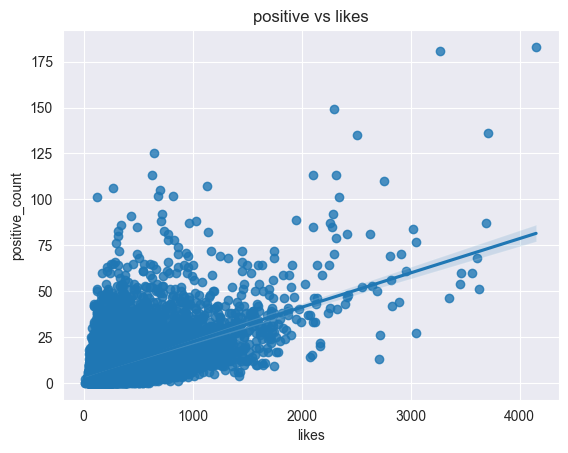

In [59]:
# your code here
# ┌(ಠ_ಠ)┘
from scipy import stats
df_vk["negative_count"] = df_vk["negative_count"].fillna(0)
df_vk["positive_count"] = df_vk["positive_count"].fillna(0)

df_vk_other = df_vk.drop(df_vk[df_vk.likes > 5000].index)
df_vk_other = df_vk_other.drop(df_vk_other[df_vk_other.positive_count > 300].index)
df_vk_other = df_vk_other.drop(df_vk_other[df_vk_other.comments > 1750].index)

import seaborn as sns
sns.regplot(data=df_vk_other, x="likes", y="positive_count").set_title("positive vs likes")

Text(0.5, 1.0, 'negative vs likes')

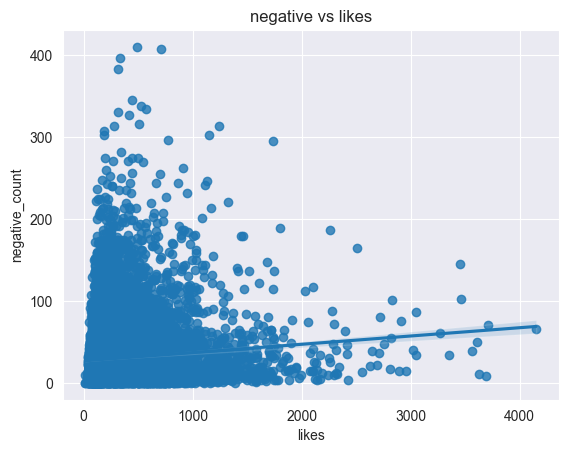

In [60]:
sns.regplot(data=df_vk_other, x="likes", y="negative_count").set_title("negative vs likes")

Text(0.5, 1.0, 'commetns vs likes')

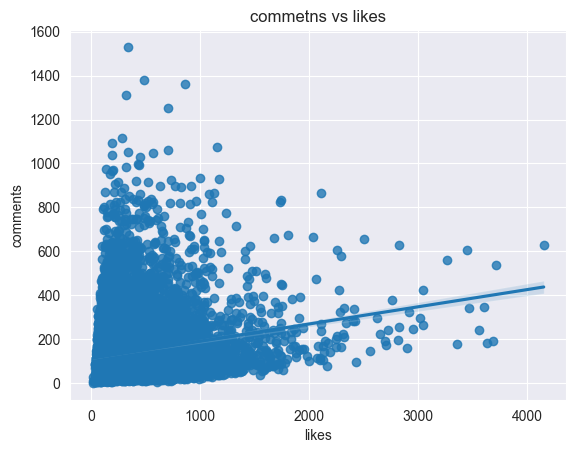

In [61]:
sns.regplot(data=df_vk_other, x="likes", y="comments").set_title("commetns vs likes")

там я сначала убрал выбросы (визуально что на графике было жестко далеко)
теперь можно сказать, что чем выше лайков, тем просто выше клмментов, но от негативных положительная зависимость значительно ниже, чем от положительных, где она оч хорошо вверх идет линия тренда вот так

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [64]:
# your code here
# ฅ^•ﻌ•^ฅ

def lkjhsdlifu(u, d):
    a = 1 + u
    b = 1 + d
    ouhpwepourth = (
            (a / (a + b))
            - 
            1.65 * np.sqrt(
        (a * b) / (
                (a + b) ** 2 * (a + b + 1)
        )
    )
    )
    return ouhpwepourth

df_vk['lower_bound'] = df_vk.apply(lambda i: lkjhsdlifu(i['positive_count'], i['comments']-i['positive_count']), axis=1)

df_vk.sort_values(by='lower_bound', ascending=False).head(10)["title"]

6651     Сборная России выиграла командный турнир на че...
6620     Россиянки заняли третье место в ските среди юн...
12529    "Ак Барс" стал трехкратным обладателем Кубка Г...
19213    Фигуристы Тарасова и Морозов победили в соревн...
2881      В Балашихе спасли провалившегося под лед ребенка
4968     Сборная России вернулась в Москву после победы...
13794                  В Финляндии появился отель на лыжах
7572     Россиянин Иван Бессонов победил в конкурсе "кл...
14020    Миленина выиграла биатлонную гонку на 12,5 км,...
13930    Вопреки всему: россияне стали вторыми на Парал...
Name: title, dtype: object

Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

In [67]:
# your code here
# ٩(⁎❛ᴗ❛⁎)۶
vkpredsdf = pd.read_csv("predvk")

In [75]:
mostlikelytags = vkpredsdf.idxmax(axis="columns")

In [77]:
idx2tag

{0: '"бессмертный полк" - 2018',
 1: '"дом.рф"',
 2: '"новая" москва',
 3: '"общественные мнения"',
 4: '"прямая линия" с путиным - 2018',
 5: '13 мая',
 6: '13-15 апреля',
 7: '17 марта',
 8: '19-25 марта',
 9: '2-15 июля 2018 года',
 10: '2002',
 11: '2003',
 12: '2004',
 13: '2005',
 14: '2007',
 15: '21-23 апреля',
 16: '22-25 марта',
 17: '23 марта 2018 года',
 18: '23-й тур чемпионата россии-2017/18 по футболу',
 19: '24-й тур чемпионата россии-2017/18 по футболу',
 20: '25-й тур чемпионата россии-2017/18 по футболу',
 21: '26-29 апреля 2018 года',
 22: '26-й тур чемпионата россии-2017/18 по футболу',
 23: '27 марта 2018 года',
 24: '27-й тур чемпионата россии-2017/18 по футболу',
 25: '28-30 апреля',
 26: '28-й тур чемпионата россии-2017/18 по футболу',
 27: '29-й тур чемпионата россии-2017/18 по футболу',
 28: '30 мая и 5 июня 2017 года',
 29: '30-й тур чемпионата россии-2017/18 по футболу',
 30: '31 марта - 1 апреля',
 31: '5-7 мая',
 32: '6-7 апреля',
 33: '7-9 апреля',
 34: 

In [79]:
taglistdecode = []
for i in tqdm(mostlikelytags):
    taglistdecode.append(idx2tag[int(i)])

  0%|          | 0/19928 [00:00<?, ?it/s]

In [80]:
df_vk["categ"] = taglistdecode
df_vk

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,negative_count,positive_count,lower_bound,categ
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,10.0,2.0,0.011095,в мире
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,11.0,3.0,0.020198,происшествия
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,4.0,3.0,0.041369,"""бессмертный полк"" - 2018"
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,10.0,2.0,0.008019,в мире
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,37.0,10.0,0.039144,в мире
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNK#,31.0,4.0,0.012124,политика
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNK#,11.0,8.0,0.087334,политика
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNK#,11.0,0.0,-0.008830,риа наука
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNK#,10.0,1.0,-0.005051,в мире


у меня оно почему-то выводит постоянно бессметрный полк как категорию дефолтную :sob:

In [87]:
df_vk.groupby('categ')["lower_bound"].apply(lambda x: sum(x.nlargest(10))).nlargest(11)

categ
спорт                        3.752163
другие виды спорта           3.439401
фигурное катание             3.393271
водные виды                  3.278439
спортивная гимнастика        3.089953
культура                     2.941746
россия                       2.899379
"бессмертный полк" - 2018    2.892792
художественная гимнастика    2.890404
происшествия                 2.853830
единоборства                 2.788593
Name: lower_bound, dtype: float64

## Метод рабочий (2023)
беру сначала предикшыны и делаю по 1 категории наиболее вероятной посту :)
я знаю что там типо несколько таргет тегоав может быть но вроде по категориям выходит в точку
короче потом просто группирую по категам
смотрю пот 10 луших новостей и потом суммирую беру топ 10 самых больших сумм

вот они

+-------------------------+
|                         |
|categ                    |
+-------------------------+
|спорт                    |
|другие виды спорта       |
|фигурное катание         |
|водные виды              |
|спортивная гимнастика    |
|культура                 |
|россия                   | - россия это круто
|"бессмертный полк" - 2018| - не считается он как дефолтная новость
|художественная гимнастика|
|происшествия             | - ахахах вот это да
|единоборства             |
+-------------------------+



__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [ ]:
# your code here
# ヾ(๑╹◡╹)ﾉ